In [4]:
# Imports needed or not
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import statsmodels.api as sm
import statsmodels.api as sm
import category_encoders as ce
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

In [242]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
# Trying to see all the columns of the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
# Read the csv's
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')
train_labels = pd.read_csv('train_labels.csv')
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
# Get some idea of the numbers I am working with
print(train_features.shape)
train_features.describe()

(59400, 40)


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


**Labels dataframe includes the status_group along with the id. The status group is the dependent variable here. The id needs to be used to track the status group.**

In [8]:
# Checking for values
train_labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**This indicates what our expectations should be for our outcomes. Function here is ~53.31%. Non-Function is ~38.42%. And, functional needs repair is ~7.27%**

In [9]:
y = train_labels.drop(columns='id')
print(train_labels.shape)

(59400, 2)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        train_features, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
    
print('X_train shape is ',X_train.shape)
print('X_test shape is ',X_test.shape)
print()
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)

X_train shape is  (44550, 40)
X_test shape is  (14850, 40)

y_train shape is  (44550, 1)
y_test shape is  (14850, 1)


In [11]:
# Baseline Prediction
majority_class = train_labels['status_group'].mode()[0]
y_pred = np.full(shape=train_labels['status_group'].shape, fill_value=majority_class)
print(train_labels.status_group.shape)
y_pred.shape

(59400,)


(59400,)

In [12]:
accuracy_score(train_labels['status_group'], y_pred)

0.543080808080808

In [13]:
# Making submission DataFrame
submission = pd.DataFrame(y_pred, columns=['status_group_included'])
submission = pd.concat([train_labels, submission], axis=1)
submission.head()

,id,status_group,status_group_included
0,69572,functional,functional
1,8776,functional,functional
2,34310,functional,functional
3,67743,non functional,functional
4,19728,functional,functional


In [14]:
submission = submission.drop(columns='status_group')
print(submission.shape)
submission.head()

(59400, 2)


,id,status_group_included
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,functional
4,19728,functional


In [15]:
# Checking for null values
train_features.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [16]:
# Filling null values with the mode
train_features['funder'] = train_features['funder'].fillna(train_features['funder'].mode()[0])
train_features['installer'] = train_features['installer'].fillna(train_features['installer'].mode()[0])
train_features['subvillage'] = train_features['subvillage'].fillna(train_features['subvillage'].mode()[0])
train_features['public_meeting'] = train_features['public_meeting'].fillna(train_features['public_meeting'].mode()[0])
train_features['scheme_management'] = train_features['scheme_management'].fillna(train_features['scheme_management'].mode()[0])
train_features['permit'] = train_features['permit'].fillna(train_features['permit'].mode()[0])
train_features['scheme_name'] = train_features['scheme_name'].fillna(train_features['scheme_name'].mode()[0])
# train_features.head()
# train_features.isnull().sum()

In [17]:
# Making all objects into numbers
def encode_cat(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

---

In [18]:
X_test_features = test_features.copy()
X_test_features.head()
# X_test_features.shape

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [19]:
X_test_features.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    783
gps_height                  0
installer                 788
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 94
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            785
recorded_by                 0
scheme_management         939
scheme_name              6839
permit                    663
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [20]:
X_test_features['funder'] = test_features['funder'].fillna(test_features['funder'].mode()[0])
X_test_features['installer'] = test_features['installer'].fillna(test_features['installer'].mode()[0])
X_test_features['subvillage'] = test_features['subvillage'].fillna(test_features['subvillage'].mode()[0])
X_test_features['public_meeting'] = test_features['public_meeting'].fillna(test_features['public_meeting'].mode()[0])
X_test_features['scheme_management'] = test_features['scheme_management'].fillna(test_features['scheme_management'].mode()[0])
X_test_features['permit'] = test_features['permit'].fillna(test_features['permit'].mode()[0])
X_test_features['scheme_name'] = test_features['scheme_name'].fillna(test_features['scheme_name'].mode()[0])

In [21]:
X_test_features.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

In [22]:
X_test_features.shape

(14358, 40)

In [23]:
# Using only numeric columns for now
X = train_features.select_dtypes('number')
X = X.drop(columns='id')
X = scale(X)

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
    
print('X_train shape is ',X_train.shape)
print('X_test shape is ',X_test.shape)
print()
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)

X_train shape is  (44550, 9)
X_test shape is  (14850, 9)

y_train shape is  (44550, 1)
y_test shape is  (14850, 1)


In [25]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_train)
accuracy_score(y_train,y_pred)

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.55672278338945

In [26]:
# Using test data
X_test_data = X_test_features.drop(columns='id')
X_test_data = X_test_data.select_dtypes('number')
X_test_data = scale(X_test_data)
#Testing with Test data
X_test_data

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


array([[-0.12798429,  1.9504066 ,  0.18408659, ..., -0.2770127 ,
         0.28136694,  0.74932705],
       [-0.12798429,  1.32999082,  0.39217066, ..., -0.37911642,
         0.23725387,  0.73672887],
       [-0.12798429,  1.32708489,  0.10442199, ..., -0.37911642,
         0.65737833,  0.74722736],
       ...,
       [-0.12798429,  1.19486514,  0.1001475 , ..., -0.37911642,
         0.02719163,  0.74722736],
       [-0.12798429,  0.50034818,  0.20570873, ..., -0.37911642,
        -0.07783948,  0.74617751],
       [-0.12798429, -0.25083439,  0.10399411, ..., -0.2770127 ,
        -0.30890794,  0.74512766]])

In [27]:
# Logistic Regression Model
y_pred = log_reg.predict(X_test_data)
prediction_df = pd.DataFrame(y_pred)
identities = pd.DataFrame(X_test_features['id'])
print(identities.shape)
test_first_pass = identities.join(prediction_df)
test_first_pass.rename(columns={0: 'status_group'}, inplace=True)

(14358, 1)


In [28]:
print(test_first_pass.shape)
test_first_pass.head()

(14358, 2)


,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [29]:
test_first_pass.to_csv(path_or_buf="/Users/danielleromanoff/Documents/Lambda/DS-Unit-2-Project-Week/Submission.csv", index=False)

In [32]:
Xtf = train_features.drop(columns='id')
Xtf_names = Xtf.select_dtypes('number').columns
coefficients = log_reg.fit(X_train, y_train).coef_[0]
print(pd.Series(coefficients, Xtf_names).to_string())

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


amount_tsh           0.547098
gps_height           0.231932
longitude            0.053451
latitude             0.005779
num_private          0.008021
region_code         -0.213749
district_code        0.080337
population           0.032038
construction_year   -0.099093


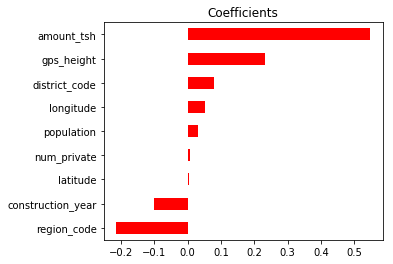

In [34]:
plt.figure(figsize = (5, 4))
plt.title('Coefficients')
pd.Series(coefficients, Xtf_names).sort_values().plot.barh(color = 'r')

In [58]:
# Encoding X_train
encode_df = train_features.copy()
encode_df = encode_cat(encode_df)
print('Encode_df shape is ',encode_df.shape)

Encode_df shape is  (59400, 40)


In [59]:
y_encode = train_labels.drop(columns='id')

In [60]:
X_encode_train, X_encode_test, y_encode_train, y_encode_test = train_test_split(
        encode_df, y_encode, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
    
print('X_encode_train shape is ',X_encode_train.shape)
print('X_encode_test shape is ',X_encode_test.shape)
print()
print('y_encode_train shape is ', y_encode_train.shape)
print('y_encode_test shape is ', y_encode_test.shape)

X_encode_train shape is  (44550, 40)
X_encode_test shape is  (14850, 40)

y_encode_train shape is  (44550, 1)
y_encode_test shape is  (14850, 1)


In [61]:
X_encode = encode_df.drop(columns='id')

In [62]:
# Using encoded data
encode_data = encode_df.drop(columns='id')
encode_data = scale(encode_data)
encode_data

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 1.89566509, -1.21879258,  0.98802182, ..., -0.53841035,
        -0.8836145 , -0.76596738],
       [-0.10597003,  1.18877426, -0.60732855, ...,  1.76507387,
        -0.8836145 , -0.76596738],
       [-0.09762988,  1.10607158,  0.02372115, ...,  1.76507387,
        -0.32226541, -0.76596738],
       ...,
       [-0.10597003, -0.96149536, -0.6303725 , ..., -0.53841035,
         0.80043277,  0.68443707],
       [-0.10597003, -1.2739277 ,  0.12830523, ..., -0.53841035,
         0.80043277,  0.68443707],
       [-0.10597003, -1.1360899 ,  1.86723713, ..., -0.53841035,
         0.80043277,  0.68443707]])

In [197]:
log_reg_encode = LogisticRegression()
log_reg_encode.fit(X_encode_train,y_encode_train)
y_pred_encode = log_reg_encode.predict(X_encode_train)
accuracy_score(y_encode_train,y_pred_encode)

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6345005611672279

In [75]:
# Encoding test features
encode_test = X_test_features.copy()
encode_test = encode_test.drop(columns='id')
encode_test = encode_cat(encode_test)
print('Encode_test shape is ',encode_test.shape)

Encode_test shape is  (14358, 39)


In [85]:
# Logistic Regression Model
# encode_y_pred = logreg_encode.predict(encode_test)
# encode_prediction = pd.DataFrame(encode_y_pred)
# identities = pd.DataFrame(X_test_features['id'])
# print(identities.shape)
# encode_first_pass = identities.join(encode_prediction)
# encode_first_pass.rename(columns={0: 'status_group'}, inplace=True)

In [339]:
print(encode_first_pass.shape)
encode_first_pass.head()

(14358, 2)


,id,status_group
0,50785,functional needs repair
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [340]:
encode_first_pass.to_csv(path_or_buf="/Users/danielleromanoff/Documents/Lambda/DS-Unit-2-Project-Week/Submission_2.csv", index=False)

In [179]:
train_eng = train_features[['id', 'gps_height', 'district_code', 'population', 'construction_year', 'water_quality',
                            'quantity', 'source']].copy()
train_eng.head()

,id,gps_height,district_code,population,construction_year,water_quality,quantity,source
0,69572,1390,5,109,1999,soft,enough,spring
1,8776,1399,2,280,2010,soft,insufficient,rainwater harvesting
2,34310,686,4,250,2009,soft,enough,dam
3,67743,263,63,58,1986,soft,dry,machine dbh
4,19728,0,1,0,0,soft,seasonal,rainwater harvesting


In [180]:
for col in train_eng.columns:
    train_eng['number of years'] = 2019 - train_eng['construction_year']
train_eng.head()

,id,gps_height,district_code,population,construction_year,water_quality,quantity,source,number of years
0,69572,1390,5,109,1999,soft,enough,spring,20
1,8776,1399,2,280,2010,soft,insufficient,rainwater harvesting,9
2,34310,686,4,250,2009,soft,enough,dam,10
3,67743,263,63,58,1986,soft,dry,machine dbh,33
4,19728,0,1,0,0,soft,seasonal,rainwater harvesting,2019


In [181]:
train_eng = train_eng.drop(columns='construction_year')

In [182]:
train_eng.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [183]:
train_eng.quantity = train_eng.quantity.replace('enough', 0)
train_eng.quantity = train_eng.quantity.replace('insufficient', 1)
train_eng.quantity = train_eng.quantity.replace('dry', 2)
train_eng.quantity = train_eng.quantity.replace('seasonal', 3)
train_eng.quantity = train_eng.quantity.replace('unknown', 4)
train_eng.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,69572,1390,5,109,soft,0,spring,20
1,8776,1399,2,280,soft,1,rainwater harvesting,9
2,34310,686,4,250,soft,0,dam,10
3,67743,263,63,58,soft,2,machine dbh,33
4,19728,0,1,0,soft,3,rainwater harvesting,2019


In [184]:
train_eng.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [185]:
train_eng.water_quality = train_eng.water_quality.replace('soft', 0)
train_eng.water_quality = train_eng.water_quality.replace('salty', 1)
train_eng.water_quality = train_eng.water_quality.replace('unknown', 2)
train_eng.water_quality = train_eng.water_quality.replace('milky', 3)
train_eng.water_quality = train_eng.water_quality.replace('coloured', 4)
train_eng.water_quality = train_eng.water_quality.replace('salty abandoned', 5)
train_eng.water_quality = train_eng.water_quality.replace('fluoride', 6)
train_eng.water_quality = train_eng.water_quality.replace('fluoride abandoned', 7)
train_eng.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,69572,1390,5,109,0,0,spring,20
1,8776,1399,2,280,0,1,rainwater harvesting,9
2,34310,686,4,250,0,0,dam,10
3,67743,263,63,58,0,2,machine dbh,33
4,19728,0,1,0,0,3,rainwater harvesting,2019


In [186]:
train_eng.source = train_eng.source.replace('spring', 0)
train_eng.source = train_eng.source.replace('shallow well', 1)
train_eng.source = train_eng.source.replace('machine dbh', 2)
train_eng.source = train_eng.source.replace('river', 3)
train_eng.source = train_eng.source.replace('rainwater harvesting', 4)
train_eng.source = train_eng.source.replace('hand dtw', 5)
train_eng.source = train_eng.source.replace('lake', 6)
train_eng.source = train_eng.source.replace('dam', 7)
train_eng.source = train_eng.source.replace('other', 8)
train_eng.source = train_eng.source.replace('unknown', 9)
train_eng.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,69572,1390,5,109,0,0,0,20
1,8776,1399,2,280,0,1,4,9
2,34310,686,4,250,0,0,7,10
3,67743,263,63,58,0,2,2,33
4,19728,0,1,0,0,3,4,2019


In [237]:
y_eng = train_labels.drop(columns='id')

In [238]:
X = train_eng.drop(columns='id')
X = scale(X)
X.shape

/Users/danielleromanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


(59400, 7)

In [239]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
        X, y_eng, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
    
print('X_train_eng shape is ',X_train_eng.shape)
print('X_test_eng shape is ',X_test_eng.shape)
print()
print('y_train_eng shape is ', y_train_eng.shape)
print('y_test_eng shape is ', y_test_eng.shape)

X_train_eng shape is  (44550, 7)
X_test_eng shape is  (14850, 7)

y_train_eng shape is  (44550, 1)
y_test_eng shape is  (14850, 1)


In [243]:
# Create pipeline
pipeline = make_pipeline(StandardScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression(multi_class='multinomial',
                                            solver='lbfgs'))

In [244]:
# Model validation.
param_grid = {
    'selectkbest__k': [1,2,3,4], 
    'logisticregression__class_weight' : [None, 'balanced']
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=3,
                         scoring='accuracy', verbose=1)

gridsearch.fit(X_train_eng, y_train_eng)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    7.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x115a09158>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=...nalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [245]:
eng_test_features = X_test_features[['id', 'gps_height', 'district_code', 'population', 'construction_year', 'water_quality',
                            'quantity', 'source']].copy()
eng_test_features.head()

,id,gps_height,district_code,population,construction_year,water_quality,quantity,source
0,50785,1996,3,321,2012,soft,seasonal,rainwater harvesting
1,51630,1569,2,300,2000,soft,insufficient,spring
2,17168,1567,2,500,2010,soft,insufficient,rainwater harvesting
3,45559,267,43,250,1987,soft,dry,shallow well
4,49871,1260,3,60,2000,soft,enough,spring


In [246]:
for col in eng_test_features.columns:
    eng_test_features['number of years'] = 2019 - eng_test_features['construction_year']
eng_test_features.head()

,id,gps_height,district_code,population,construction_year,water_quality,quantity,source,number of years
0,50785,1996,3,321,2012,soft,seasonal,rainwater harvesting,7
1,51630,1569,2,300,2000,soft,insufficient,spring,19
2,17168,1567,2,500,2010,soft,insufficient,rainwater harvesting,9
3,45559,267,43,250,1987,soft,dry,shallow well,32
4,49871,1260,3,60,2000,soft,enough,spring,19


In [247]:
eng_test_features = eng_test_features.drop(columns='construction_year')

In [248]:
eng_test_features.quantity = eng_test_features.quantity.replace('enough', 0)
eng_test_features.quantity = eng_test_features.quantity.replace('insufficient', 1)
eng_test_features.quantity = eng_test_features.quantity.replace('dry', 2)
eng_test_features.quantity = eng_test_features.quantity.replace('seasonal', 3)
eng_test_features.quantity = eng_test_features.quantity.replace('unknown', 4)
eng_test_features.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,50785,1996,3,321,soft,3,rainwater harvesting,7
1,51630,1569,2,300,soft,1,spring,19
2,17168,1567,2,500,soft,1,rainwater harvesting,9
3,45559,267,43,250,soft,2,shallow well,32
4,49871,1260,3,60,soft,0,spring,19


In [249]:
eng_test_features.water_quality = eng_test_features.water_quality.replace('soft', 0)
eng_test_features.water_quality = eng_test_features.water_quality.replace('salty', 1)
eng_test_features.water_quality = eng_test_features.water_quality.replace('unknown', 2)
eng_test_features.water_quality = eng_test_features.water_quality.replace('milky', 3)
eng_test_features.water_quality = eng_test_features.water_quality.replace('coloured', 4)
eng_test_features.water_quality = eng_test_features.water_quality.replace('salty abandoned', 5)
eng_test_features.water_quality = eng_test_features.water_quality.replace('fluoride', 6)
eng_test_features.water_quality = eng_test_features.water_quality.replace('fluoride abandoned', 7)
eng_test_features.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,50785,1996,3,321,0,3,rainwater harvesting,7
1,51630,1569,2,300,0,1,spring,19
2,17168,1567,2,500,0,1,rainwater harvesting,9
3,45559,267,43,250,0,2,shallow well,32
4,49871,1260,3,60,0,0,spring,19


In [250]:
eng_test_features.source = eng_test_features.source.replace('spring', 0)
eng_test_features.source = eng_test_features.source.replace('shallow well', 1)
eng_test_features.source = eng_test_features.source.replace('machine dbh', 2)
eng_test_features.source = eng_test_features.source.replace('river', 3)
eng_test_features.source = eng_test_features.source.replace('rainwater harvesting', 4)
eng_test_features.source = eng_test_features.source.replace('hand dtw', 5)
eng_test_features.source = eng_test_features.source.replace('lake', 6)
eng_test_features.source = eng_test_features.source.replace('dam', 7)
eng_test_features.source = eng_test_features.source.replace('other', 8)
eng_test_features.source = eng_test_features.source.replace('unknown', 9)
eng_test_features.head()

,id,gps_height,district_code,population,water_quality,quantity,source,number of years
0,50785,1996,3,321,0,3,4,7
1,51630,1569,2,300,0,1,0,19
2,17168,1567,2,500,0,1,4,9
3,45559,267,43,250,0,2,1,32
4,49871,1260,3,60,0,0,0,19


In [251]:
# Using test data
eng_test_data = eng_test_features.drop(columns='id')
eng_test_data = scale(eng_test_data)
#Testing with Test data
eng_test_data

array([[ 1.9504066 , -0.2770127 ,  0.28136694, ...,  2.30668464,
         1.5863442 , -0.74932705],
       [ 1.32999082, -0.37911642,  0.23725387, ...,  0.28010498,
        -1.0264152 , -0.73672887],
       [ 1.32708489, -0.37911642,  0.65737833, ...,  0.28010498,
         1.5863442 , -0.74722736],
       ...,
       [ 1.19486514, -0.37911642,  0.02719163, ...,  0.28010498,
         3.54591375, -0.74722736],
       [ 0.50034818, -0.37911642, -0.07783948, ...,  0.28010498,
         0.93315435, -0.74617751],
       [-0.25083439, -0.2770127 , -0.30890794, ...,  1.29339481,
        -1.0264152 , -0.74512766]])

In [252]:
# Gridsearch results with test data
y_pred = gridsearch.predict(eng_test_data)
eng_prediction = pd.DataFrame(y_pred)
identities = pd.DataFrame(eng_test_features['id'])
print(identities.shape)
test_eng_first = identities.join(eng_prediction)
test_eng_first.rename(columns={0: 'status_group'}, inplace=True)

(14358, 1)


In [253]:
print(test_eng_first.shape)
test_eng_first.head()

(14358, 2)


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [254]:
test_eng_first.to_csv(path_or_buf="/Users/danielleromanoff/Documents/Lambda/DS-Unit-2-Project-Week/Submission_3.csv", index=False)